In [1]:
#importing libraries 
import re
import nltk
import numpy as np
import pandas  as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Embedding, Dense,LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,accuracy_score
from tensorflow.keras.models import load_model


In [2]:
#reading the csv file
df  =pd.read_csv("IMDB Dataset.csv")

#first five rows
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [5]:
#checking the null values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

No null value

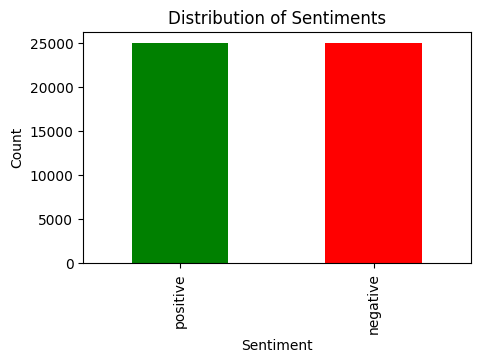

In [6]:
#check the distribution  of the data

plt.figure(figsize=(5, 3))

df['sentiment'].value_counts().plot(kind='bar',color=['green','red'])

plt.title('Distribution of Sentiments')

plt.xlabel('Sentiment')

plt.ylabel('Count')

plt.show()


Balanced Dataset 

In [7]:
df['sentiment'].value_counts()


sentiment
positive    25000
negative    25000
Name: count, dtype: int64

lets do data preprocessing 


Review contain html tags and stopword , other regular expressions which  are not much important 

In [8]:
# stopwords package downloading
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def data_preprocess(text):

    # Convert text to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove extra white spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)


    return text

In [10]:
# Apply the updated function to the 'review' column
df['review'] = df['review'].apply(data_preprocess)

In [11]:
# Display the first few entries of the 'review' column to verify the changes
df.review

0        one reviewers mentioned watching oz episode yo...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically theres family little boy jake thinks...
4        petter matteis love time money visually stunni...
                               ...                        
49995    thought movie right good job wasnt creative or...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary schools n...
49998    im going disagree previous comment side maltin...
49999    one expects star trek movies high art fans exp...
Name: review, Length: 50000, dtype: object

now text is clean 

In [12]:
# Check data types of 'review' column
print(df['sentiment'].apply(type).value_counts())


sentiment
<class 'str'>    50000
Name: count, dtype: int64


In [13]:
#lets replace positive with - 0, and negative with - 1
df['sentiment']=df['sentiment'].replace({'positive':1,'negative':0})

In [14]:
df.head()

,review,sentiment
0,one reviewers mentioned watching oz episode yo...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically theres family little boy jake thinks...,0
4,petter matteis love time money visually stunni...,1


In [15]:
#lets split the data into train and test

train_data , test_data = train_test_split(df, test_size=0.20,random_state=42)

In [16]:
#checking shape of the data
train_data.shape,test_data.shape

((40000, 2), (10000, 2))

In [17]:
#geeting info about length  of review etc.

review_lengths = train_data['review'].apply(lambda x: len(x.split()))
max_review_length = review_lengths.max()
avg_review_length = review_lengths.mean()
percentile_90_length = np.percentile(review_lengths, 90)

In [18]:
print(f"Max review length: {max_review_length}")
print(f"Average review length: {avg_review_length}")
print(f"90th percentile review length: {percentile_90_length}")

Max review length: 1420
Average review length: 118.49135
90th percentile review length: 233.0


In [19]:
#Tokenization

tokenizer = Tokenizer(num_words=10000)

#fitting the tokenizer on the data
tokenizer.fit_on_texts(train_data['review']) #  processes  text data and creates a mapping of words to integers.

X_train = pad_sequences(tokenizer.texts_to_sequences(train_data['review']),maxlen=233,padding='pre')#texts_to_sequences help to replace the word with integer  based on vocabulary we created

X_test = pad_sequences(tokenizer.texts_to_sequences(test_data['review']),maxlen=233,padding='pre')


In [20]:
#seprating the target variable
y_train = np.array(train_data['sentiment']).reshape(-1,1)
y_test = np.array(test_data['sentiment']).reshape(-1,1)

In [21]:
# Optional: Print first few values to verify
print(f"First few y_train values: {y_train[:5]}")
print(f"First few y_test values: {y_test[:5]}")

First few y_train values: [[0]
 [0]
 [1]
 [0]
 [0]]
First few y_test values: [[1]
 [1]
 [0]
 [1]
 [0]]


In [22]:
#lets see how it looks
print(X_train)

#checking the shape
X_train.shape ,y_train.shape, X_test.shape , y_test.shape

[[   0    0    0 ...  108  230 3604]
 [   0    0    0 ...  103   20   29]
 [   0    0    0 ...  200  605   11]
 ...
 [   0    0    0 ... 1001 1468  511]
 [   0    0    0 ...  142   29 6846]
 [   0    0    0 ...  366   12 1802]]


((40000, 233), (40000, 1), (10000, 233), (10000, 1))

Now we have our X_train ,X_test,y_train,y_test

*lets create  our model - LSTM


In [23]:
# Instantiate the Sequential model
model = Sequential()

# Add Embedding layer
model.add(Embedding(input_dim=10001, output_dim=128, input_length=233))

# Add GRU layers
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))

# Add a Dense output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping 
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

#how the model looks like
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 233, 128)          1280128   
                                                                 
 lstm (LSTM)                 (None, 233, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 256)               394240    
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1806209 (6.89 MB)
Trainable params: 1806209 (6.89 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# Fit the model
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validtion_split=0.2, 
                    callbacks=[early_stopping])


Epoch 1/10
2000/2000 [==============================] - 3720s 2s/step - loss: 0.3682 - accuracy: 0.8414 - val_loss: 0.3931 - val_accuracy: 0.8411
Epoch 2/10
2000/2000 [==============================] - 4226s 2s/step - loss: 0.2370 - accuracy: 0.9104 - val_loss: 0.3047 - val_accuracy: 0.8774
Epoch 3/10
2000/2000 [==============================] - 5098s 3s/step - loss: 0.1795 - accuracy: 0.9333 - val_loss: 0.3283 - val_accuracy: 0.8752
Epoch 4/10
2000/2000 [==============================] - 3603s 2s/step - loss: 0.1264 - accuracy: 0.9542 - val_loss: 0.3726 - val_accuracy: 0.8679
Epoch 5/10
2000/2000 [==============================] - 3717s 2s/step - loss: 0.0908 - accuracy: 0.9693 - val_loss: 0.4405 - val_accuracy: 0.8619
Epoch 6/10
2000/2000 [==============================] - 3537s 2s/step - loss: 0.0691 - accuracy: 0.9775 - val_loss: 0.4885 - val_accuracy: 0.8710


<Axes: >

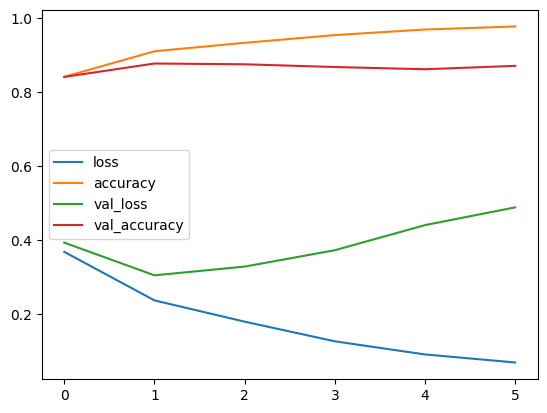

In [25]:
pd.DataFrame(history.history).plot()

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X_test, y_true, threshold=0.5):
  
    # Get model predictions
    y_pred_prob = model.predict(X_test)
    
    # Binarize predictions based on the threshold
    y_pred = (y_pred_prob >= threshold).astype(int)
    
    # Calculate precision, recall, and f1 score
    accuracy = accuracy_score(y_true,y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


313/313 [==============================] - 133s 421ms/step
Accuracy: 0.88
Precision: 0.86
Recall: 0.91
F1 Score: 0.89


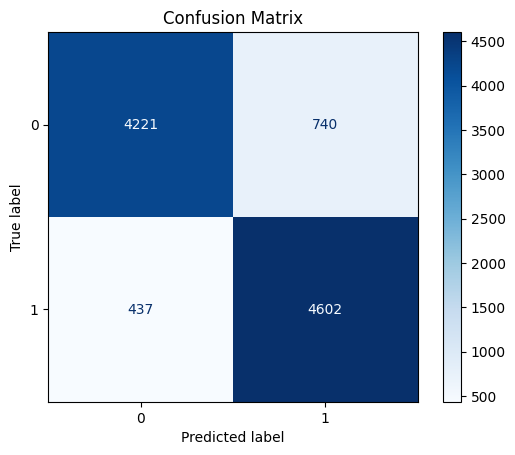

In [27]:
#evaluate the model
evaluate_model(model,X_test,y_test)

lets save our model

In [28]:
# Assuming 'model' is your trained Keras model

# Function to save the model
def save_model(model, model_name):
    # Save the model directly in the current directory
    model.save(model_name)
    print(f'Model saved as {model_name}')

# Save the model with the specified name
save_model(model, 'sentiment_analysis.h5')  # Save the model to the current directory as 'sentiment_analysis.h5'


c:\Users\harsh\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as sentiment_analysis.h5


In [29]:
# Function to load the model
def load_saved_model(model_name):
    # Load the model from the current directory
    model = load_model(model_name)
    print(f'Model loaded from {model_name}')
    return model

# Load the saved model
model = load_saved_model('sentiment_analysis.h5')


Model loaded from sentiment_analysis.h5


In [32]:
def predict_sentiment(text):
    # Preprocess the text
    processed_text = data_preprocess(text)
    
    # Tokenize and pad the text
    sequences = tokenizer.texts_to_sequences([processed_text])
    padded_sequences = pad_sequences(sequences, maxlen=233, padding='pre')
    
    # Predict sentiment
    prediction = model.predict(padded_sequences)
    
    # Convert prediction to binary sentiment (0 or 1)
    if  int(prediction[0] > 0.5) == 1: return "Positive "
    else: return "Negative"

In [34]:
text  = "the movie was soo bad  i cannot watch this movie again and again "
predict_sentiment(text)

1/1 [==============================] - 0s 214ms/step


'Negative'